# Evaluation

In [ ]:
import pandas as pd
from plotnine import (
    aes,
    element_text,
    expand_limits,
    facet_grid,
    facet_wrap,
    geom_bar,
    geom_col,
    geom_hline,
    geom_point,
    ggplot,
    guide_legend,
    labs,
    scale_alpha_manual,
    scale_color_manual,
    scale_fill_manual,
    scale_y_continuous,
    theme,
    theme_bw,
    ylim,
)

from config import MODEL_NAMES, ROOT

In [2]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha="center", ma="right"),
        axis_text_y=element_text(size=8),
    )

In [3]:
MODEL_COLORS = {
    "Ensemble": "#009E73",
    "LightGBM": "#B30000",
    "LightGBM-NoCovariates": "#B30000",
    "LightGBM-NoCovid": "#B30000",
    "LightGBM-Oracle": "#B30000",
    "LightGBM-Discard": "#B30000",
    "LightGBM-Naive": "#B30000",
    "TSMixer": "#E69F00",
    "TSMixer-NoCovariates": "#E69F00",
    "TSMixer-NoCovid": "#E69F00",
    "TSMixer-Oracle": "#E69F00",
    "TSMixer-Discard": "#E69F00",
    "TSMixer-Naive": "#E69F00",
    "hhh4": "#3C4AAD",
    "hhh4-NoCovid": "#3C4AAD",
    "hhh4-Oracle": "#3C4AAD",
    "hhh4-Shuffle": "#3C4AAD",
    "hhh4-Skip": "#3C4AAD",
    "hhh4-Uncorrected": "#3C4AAD",
    "TSCount-NB-S": "#69e2d1",
    "TSCount-Pois": "#69e2d1",
    "Nowcast": "#56B4E9",
    "Historical": "#000000",
    "Persistence": "#80471C",
}

In [4]:
WIS_ALPHA = {"underprediction": 0.9, "spread": 0.5, "overprediction": 0.1}

In [5]:
MODEL_ORDER = [
    "Nowcast",
    "Ensemble",
    "LightGBM",
    "LightGBM-NoCovariates",
    "LightGBM-NoCovid",
    "LightGBM-Oracle",
    "LightGBM-Discard",
    "LightGBM-Naive",
    "TSMixer",
    "TSMixer-NoCovariates",
    "TSMixer-NoCovid",
    "TSMixer-Oracle",
    "TSMixer-Discard",
    "TSMixer-Naive",
    "hhh4",
    "hhh4-Shuffle",
    "hhh4-NoCovid",
    "hhh4-Oracle",
    "hhh4-Skip",
    "hhh4-Uncorrected",
    "TSCount-NB-S",
    "TSCount-Pois",
    "Persistence",
    "Historical",
]

In [6]:
MAIN_MODELS = ["Ensemble", "LightGBM", "TSMixer", "hhh4", "Historical", "Persistence"]

# Prepare scores

In [ ]:
def load_scores(filename, by_horizon=False, by_age=False, long_format=False):
    df = pd.read_csv(ROOT / "results" / "scores" / filename)
    df.model = df.model.replace(MODEL_NAMES)

    if "level" in df.columns:
        df["level"] = pd.Categorical(df["level"], categories=["national", "age"], ordered=True)

    if long_format:
        df_long = pd.melt(
            df_wide,
            id_vars=["level", "model"],
            value_vars=["wis", "underprediction", "spread", "overprediction", "ae"],
            var_name="metric",
            value_name="value",
        )

    return df

In [ ]:
df_wide = load_scores("scores.csv")

In [9]:
df_long = pd.melt(
    df_wide,
    id_vars=["level", "model"],
    value_vars=["wis", "underprediction", "spread", "overprediction", "ae"],
    var_name="metric",
    value_name="value",
)

# Plots

In [ ]:
def plot_total_scores(df_long, models=None):
    if models is not None:
        df_long = df_long[df_long.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_long.model.unique()]
    df_long["model"] = pd.Categorical(df_long["model"], categories=model_order, ordered=True)

    p = (
        ggplot()
        + facet_wrap(
            "~level",
            nrow=1,
            scales="free_y",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + geom_point(
            df_long[df_long.metric == "ae"],
            aes(x="model", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            df_long[df_long.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            df_long[~df_long.metric.isin(["wis", "ae"])],
            aes(x="model", y="value", fill="model", alpha="metric", color="model"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top")
    )
    return p

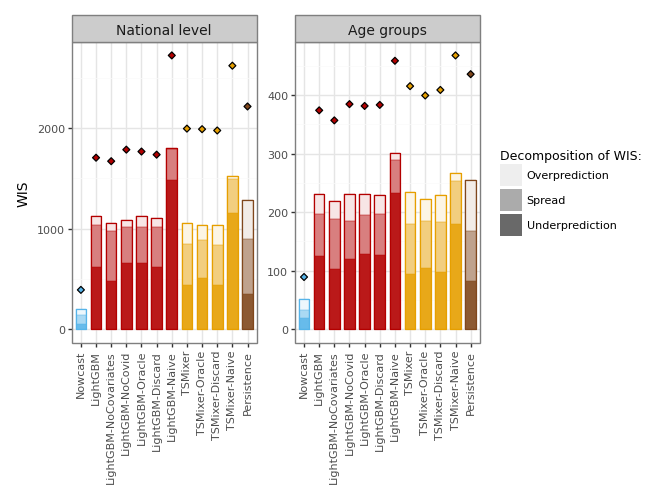

In [11]:
p = plot_total_scores(df_long, models=None)
p

In [12]:
# p.save("../figures/wis.pdf", width=160, height=70, units="mm", dpi=600, verbose=False)

In [ ]:
def plot_coverage(df_wide, models=None):
    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide["model"] = pd.Categorical(df_wide["model"], categories=model_order, ordered=True)

    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x="model"))
        + facet_wrap(
            "~level",
            nrow=1,
            scales="fixed",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + expand_limits(y=1)  # Ensure y-axis starts at 1
        # Add columns for 95% and 50% coverage with respective alpha transparency
        + geom_col(aes(y="c95"), width=0.7, fill="white", show_legend={"fill": False})
        + geom_col(
            aes(y="c95", fill="model", alpha='"95%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_col(
            aes(y="c50", fill="model", alpha='"50%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        # Horizontal dashed lines at y = 0.5 and y = 0.95
        + geom_hline(yintercept=[0.5, 0.95], linetype="dashed")
        # Customize y-axis labels to display "0" instead of omitting 0
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])
        # Labels for axes, color, and alpha legend
        + labs(x="", y="Empirical coverage", color="Model", alpha="Prediction interval: ")
        # Conditional color mapping for fill
        + scale_fill_manual(values=MODEL_COLORS)
        # Flip coordinates to make x-axis vertical
        # + coord_flip()
        # Custom alpha levels for each bar transparency
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=False))
        # Basic theme with customized legend position and alignment
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top", panel_spacing=0.025)
    )

    return p

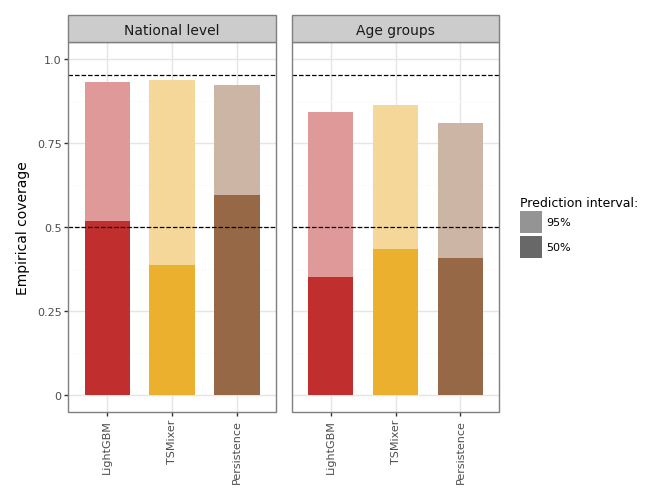

In [14]:
p = plot_coverage(df_wide, MAIN_MODELS)
p

In [15]:
# p.save(
#     "../figures/coverage.pdf", width=160, height=70, units="mm", dpi=600, verbose=False
# )

## By age group

In [16]:
scores_age = load_scores("scores_age.csv")

In [17]:
scores_age = pd.melt(
    scores_age,
    id_vars=["age_group", "model"],
    value_vars=["wis", "underprediction", "spread", "overprediction", "ae"],
    var_name="metric",
    value_name="value",
)

In [ ]:
def plot_scores_by_age_group(scores, models=None):
    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    plot = (
        ggplot()
        + geom_point(
            scores[scores.metric == "ae"],
            aes(x="model", y="value", fill="model"),
            shape="D",
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[~scores.metric.isin(["wis", "ae"])],
            aes(x="model", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap("~age_group")
        + theme_bw()
        + custom_theme()
        + theme(legend_position="right", legend_title_position="top")
    )

    return plot

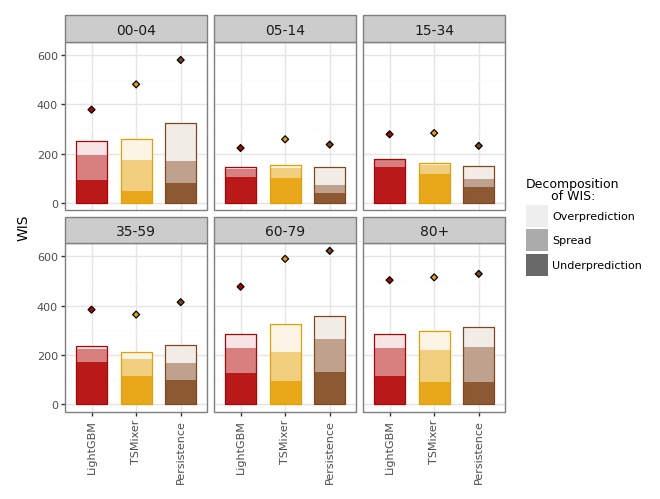

In [19]:
p = plot_scores_by_age_group(scores_age, MAIN_MODELS)
p

In [20]:
# p.save(
#     "../figures/wis_age.pdf", width=160, height=100, units="mm", dpi=600, verbose=False
# )

## By horizon

In [21]:
scores_horizon = load_scores("scores_horizon.csv")

In [22]:
scores_horizon = pd.melt(
    scores_horizon,
    id_vars=["level", "horizon", "model"],
    value_vars=["wis", "underprediction", "spread", "overprediction"],
    var_name="metric",
    value_name="value",
)

In [ ]:
def plot_scores_by_horizon_and_model(df, level="national", models=None):
    scores = df[df.level == level].copy()

    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    plot = (
        ggplot()
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="model", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric != "wis"],
            aes(x="model", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(
            x="",
            y="WIS",
            color="Model",
            alpha="Decomposition of WIS:",
            title="WIS by horizon",
        )
        + facet_grid(cols="horizon", scales="free", space="free")  # Create a facet for each horizon
        # + facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
            # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
            # axis_text_y=element_text(size=7)
        )
    )

    return plot

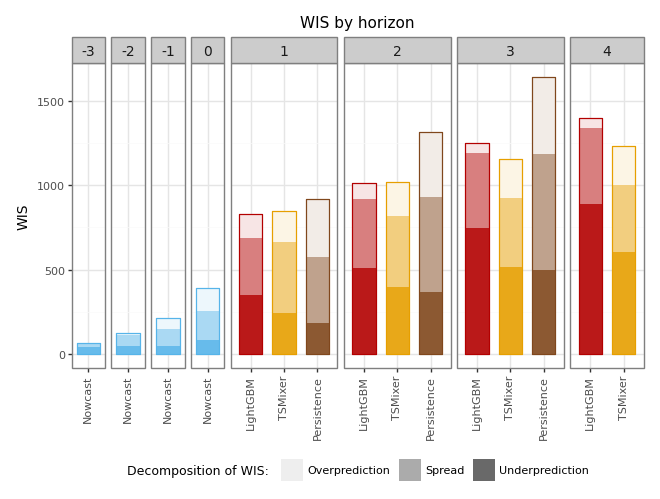

In [24]:
p = plot_scores_by_horizon_and_model(scores_horizon, "national", ["Nowcast"] + MAIN_MODELS)
p

In [25]:
# p.save(
#     "../figures/wis_national_horizon.pdf",
#     width=170,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

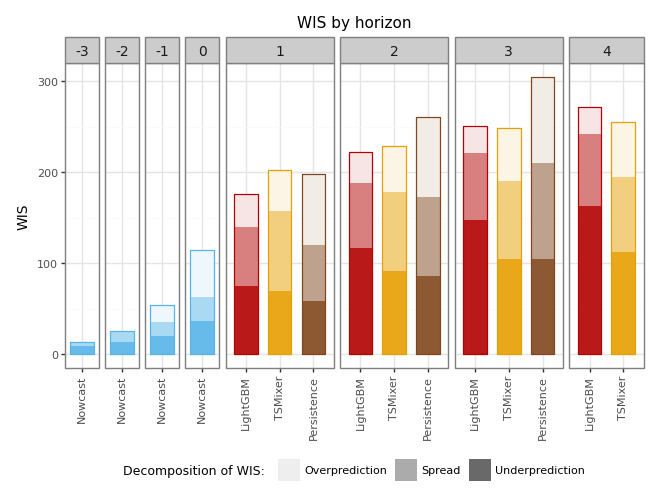

In [26]:
p = plot_scores_by_horizon_and_model(scores_horizon, "age", ["Nowcast"] + MAIN_MODELS)
p

In [27]:
# p.save(
#     "../figures/wis_age_horizon.pdf",
#     width=170,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

# Coverage by horizon

In [28]:
scores_horizon = load_scores("scores_horizon.csv")

In [ ]:
def plot_coverage_by_horizon(df_wide, level="national", models=None):
    df_wide = df_wide[df_wide.level == level].copy()

    if models is not None:
        df_wide = df_wide[df_wide.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in df_wide.model.unique()]
    df_wide["model"] = pd.Categorical(df_wide["model"], categories=model_order, ordered=True)

    alphas = {"50%": 0.7, "95%": 0.4}

    p = (
        ggplot(df_wide, aes(x="model"))
        + facet_wrap(
            "~level",
            nrow=1,
            scales="fixed",
            labeller=lambda x: ("National level" if x == "national" else "Age groups"),
        )
        + expand_limits(y=1)  # Ensure y-axis starts at 1
        # Add columns for 95% and 50% coverage with respective alpha transparency
        + geom_col(aes(y="c95"), width=0.7, fill="white", show_legend={"fill": False})
        + geom_col(
            aes(y="c95", fill="model", alpha='"95%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        + geom_col(
            aes(y="c50", fill="model", alpha='"50%"'),
            width=0.7,
            show_legend={"fill": False},
        )
        # Horizontal dashed lines at y = 0.5 and y = 0.95
        + geom_hline(yintercept=[0.5, 0.95], linetype="dashed")
        # Customize y-axis labels to display "0" instead of omitting 0
        + scale_y_continuous(labels=lambda y: ["0" if val == 0 else val for val in y])
        # Labels for axes, color, and alpha legend
        + labs(
            x="",
            y="Empirical coverage",
            color="Model",
            alpha="Prediction interval: ",
            title="Coverage by horizon",
        )
        # Conditional color mapping for fill
        + scale_fill_manual(values=MODEL_COLORS)
        # Flip coordinates to make x-axis vertical
        # + coord_flip()
        # Custom alpha levels for each bar transparency
        + scale_alpha_manual(values=alphas, guide=guide_legend(reverse=True))
        # Create a facet for each horizon
        + facet_grid(cols="horizon", scales="free", space="free")
        # Basic theme with customized legend position and alignment
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
            # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
            # axis_text_y=element_text(size=7)
            # panel_spacing=0.025
        )
    )

    return p

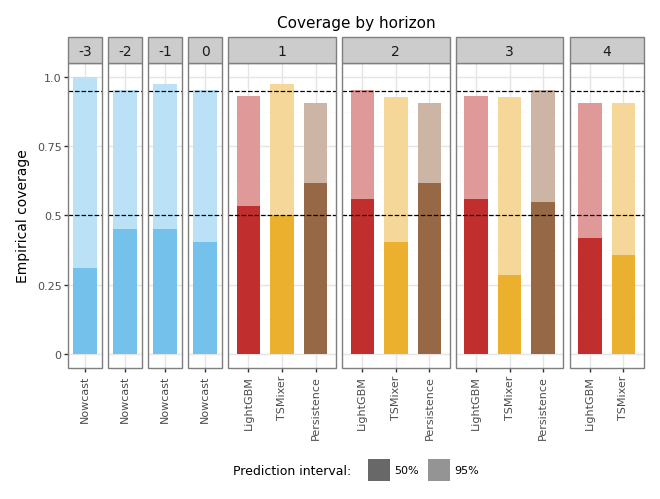

In [30]:
p = plot_coverage_by_horizon(scores_horizon, "national", ["Nowcast"] + MAIN_MODELS)
p

In [31]:
# p.save(
#     "../figures/coverage_national_horizon.pdf",
#     width=170,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

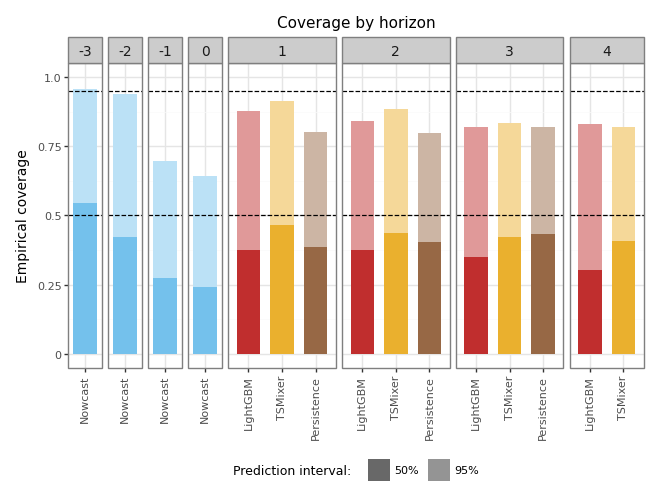

In [32]:
p = plot_coverage_by_horizon(scores_horizon, "age", ["Nowcast"] + MAIN_MODELS)
p

In [33]:
# p.save(
#     "../figures/coverage_age_horizon.pdf",
#     width=170,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

# Compare model variants

In [34]:
df_wide = load_scores("scores.csv")

df_long = pd.melt(
    df_wide,
    id_vars=["level", "model"],
    value_vars=["wis", "underprediction", "spread", "overprediction", "ae"],
    var_name="metric",
    value_name="value",
)

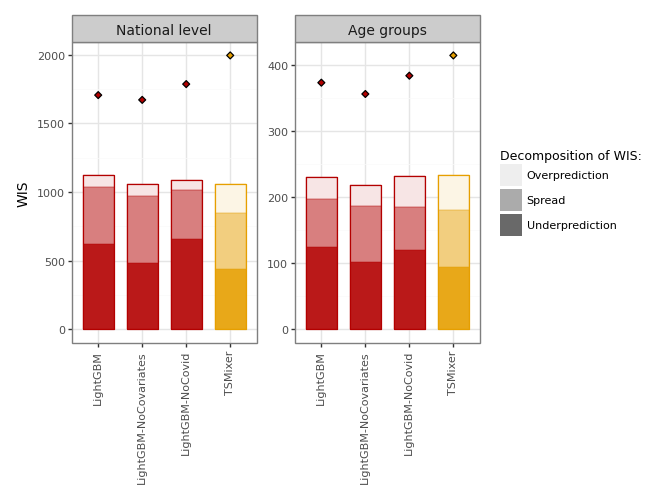

In [35]:
p = plot_total_scores(
    df_long,
    models=[
        "LightGBM",
        "LightGBM-NoCovariates",
        "LightGBM-NoCovid",
        "TSMixer",
        "TSMixer-NoCovariates",
        "TSMixer-NoCovid",
        "hhh4",
        "hhh4-Shuffle",
        "hhh4-NoCovid",
        "TSCount-NB-S",
        "TSCount-NB",
        "TSCount-Pois",
    ],
)
p

In [36]:
# p.save(
#     "../figures/wis_model_variants.pdf",
#     width=160,
#     height=80,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

# Variants by horizon

In [37]:
df_wide = load_scores("scores_horizon.csv")

df_long = pd.melt(
    df_wide,
    id_vars=["level", "horizon", "model"],
    value_vars=["wis", "underprediction", "spread", "overprediction"],
    var_name="metric",
    value_name="value",
)

In [ ]:
df_long["class"] = df_long.model.apply(lambda x: x.split("-")[0])
df_long["variant"] = df_long.model.apply(lambda x: x.split("-")[-1])
df_long.variant = df_long.variant.replace({"LightGBM": "Standard", "TSMixer": "Standard", "hhh4": "Standard"})
df_long["variant"] = pd.Categorical(
    df_long["variant"],
    categories=[
        "Nowcast",
        "Standard",
        "NoCovariates",
        "NoCovid",
        "Oracle",
        "Discard",
        "Naive",
        "Ensemble",
        "Persistence",
        "Historical",
    ],
    ordered=True,
)

In [39]:
df_long2 = df_long[df_long.horizon >= 0].copy()

df_now = df_long2[df_long2.model == "Nowcast"].copy()

df_now["class"] = "LightGBM"

for c in ["LightGBM", "TSMixer", "hhh4"]:
    df_now["class"] = c
    df_long2 = pd.concat([df_long2, df_now])

df_long2 = df_long2[df_long2["class"] != "Nowcast"]

In [40]:
# df_long2.variant = df_long2.variant.cat.rename_categories(
#     {"Standard": "Coupling", "Skip": "Discard", "Uncorrected": "Naive"}
# )

In [41]:
df_long2.model.unique()

array(['LightGBM-Discard', 'TSMixer-Discard', 'LightGBM-NoCovid',
       'LightGBM-Oracle', 'LightGBM-NoCovariates', 'TSMixer-Oracle',
       'LightGBM', 'TSMixer', 'Persistence', 'TSMixer-Naive',
       'LightGBM-Naive', 'Nowcast'], dtype=object)

In [ ]:
def plot_variants_by_horizon(df, level="national", models=None, ymax="auto"):
    scores = df[df.level == level].copy()

    if models is not None:
        scores = scores[scores.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in scores.model.unique()]
    scores["model"] = pd.Categorical(scores["model"], categories=model_order, ordered=True)

    if ymax == "auto":
        ymax = scores.value.max() * 1.05

    plot = (
        ggplot()
        + geom_bar(
            scores[scores.metric == "wis"],
            aes(x="variant", y="value", color="model"),
            fill="white",
            stat="identity",
            width=0.7,
            show_legend=False,
        )
        + geom_bar(
            scores[scores.metric != "wis"],
            aes(x="variant", y="value", fill="model", alpha="metric"),
            size=0.1,
            stat="identity",
            width=0.7,
            show_legend={"color": False, "fill": False, "alpha": True},
        )
        + scale_color_manual(values=MODEL_COLORS)
        + scale_fill_manual(values=MODEL_COLORS)
        + scale_alpha_manual(
            values=WIS_ALPHA,
            labels=["Overprediction", "Spread", "Underprediction"],
            guide=guide_legend(reverse=False),
        )
        + labs(
            x="",
            y="WIS",
            color="Model",
            alpha="Decomposition of WIS:",
            title="WIS by horizon",
        )
        + facet_grid(cols="horizon", rows="class", scales="free", space="free")  # Create a facet for each horizon
        # + facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + custom_theme()
        + theme(
            legend_position="bottom",
            legend_title_position="left",
            # axis_text_x=element_text(size=7, rotation=90, ha='center', ma='right'),
            # axis_text_y=element_text(size=7)
        )
        + ylim(0, ymax)
    )

    return plot

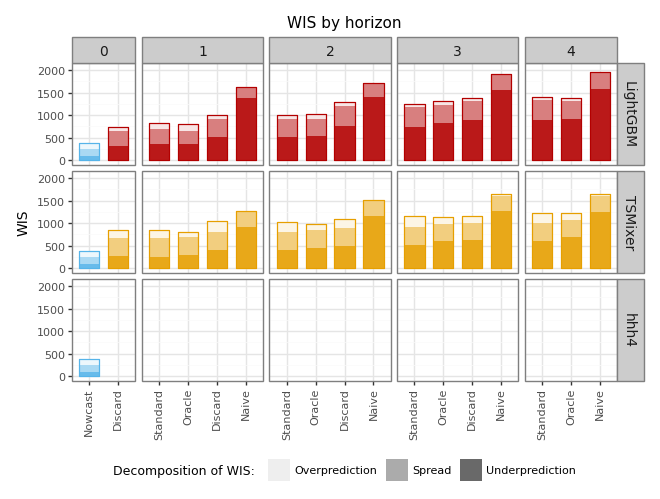

In [43]:
p = plot_variants_by_horizon(
    df_long2,
    "national",
    [
        "LightGBM",
        "LightGBM-Oracle",
        "LightGBM-Discard",
        "LightGBM-Naive",
        "TSMixer",
        "TSMixer-Oracle",
        "TSMixer-Discard",
        "TSMixer-Naive",
        "hhh4",
        "hhh4-Oracle",
        "hhh4-Discard",
        "hhh4-Naive",
        "Nowcast",
    ],
)
p

In [44]:
# p.save(
#     "../figures/wis_variants_horizon.pdf",
#     width=130,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )

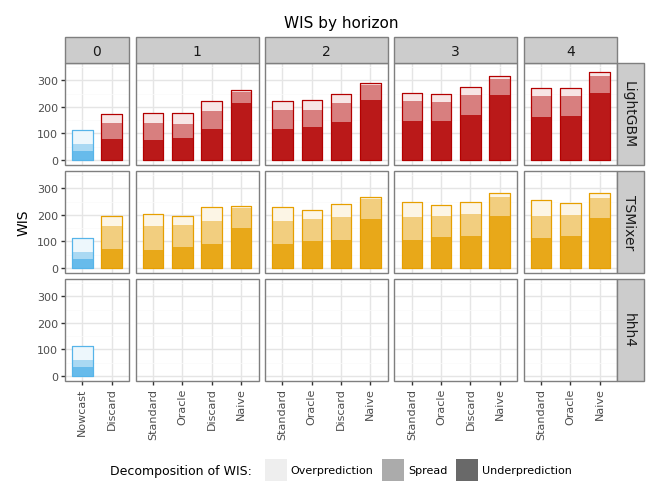

In [45]:
p = plot_variants_by_horizon(
    df_long2,
    "age",
    [
        "LightGBM",
        "LightGBM-Oracle",
        "LightGBM-Discard",
        "LightGBM-Naive",
        "TSMixer",
        "TSMixer-Oracle",
        "TSMixer-Discard",
        "TSMixer-Naive",
        "hhh4",
        "hhh4-Oracle",
        "hhh4-Discard",
        "hhh4-Naive",
        "Nowcast",
    ],
)
p

In [46]:
# p.save(
#     "../figures/wis_variants_horizon_age.pdf",
#     width=130,
#     height=100,
#     units="mm",
#     dpi=600,
#     verbose=False,
# )